**Train-Valid:** 2011-2019  
**Test:** 2020 and 2021

In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1
!pip install scikeras

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 51.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Packages & Data

In [2]:
import sys
import os
import numpy as np
import pandas as pd
# import calendar
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,metrics
import tensorflow.keras.backend as K
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,GRU,Conv1D,Conv2D,Flatten,Input,ConvLSTM1D,ConvLSTM2D,Dropout,BatchNormalization
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from collections import Counter, defaultdict
import pickle
seed=42


In [3]:
print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.utils.set_random_seed(seed)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path



Importing from DS_Modules/CA4021


In [7]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score,score_model

# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path,'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path,'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [8]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']
# selected variables from XGBoost notebook
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

dates = df_train.date_time
X = df_train[numerical + categorical + vis_vars].reset_index(drop=True)
y = X.pop(target)

# create train and test from X, without including df_test
pre_X_train, pre_X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.23, shuffle=False, random_state=seed)

# creating training sets using only the selected features
X_train, X_valid = preprocess(pre_X_train, pre_X_valid, cat_vars=cat_vars_sel, num_vars=num_vars_sel)

# create training data using all the variables df_train (for comparison)
X_train_all, X_test_all = preprocess(pre_X_train, pre_X_valid, cat_vars=categorical, num_vars=numerical)

In [9]:
pre_X_valid.head()

,clow,cmedium,chigh,nlc,ntot,nsig1,nsig2,nsig3,nsig4,tsig4,duration,sunshine,dir,speed,vis,ptend,cbl,drybulb,wetbulb,dewpt,vp,rh,hlc,hsig1,hsig2,hsig3,hsig4,ceiling,dos,rainfall,tabdir,dni,temp_dew_dist,rainfall12hma,fog_state,season,tsig1,tsig2,tsig3,pchar,vis_hr1,fog_formation,fog_dissipation,transition
60743,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,22,8,25000,1.7,1017.6,8.7,7.3,5.7,9.1,81,18,18,32.0,0.0,0.0,32,0.0,0.0,22,0,3.0,-8.881784e-15,no fog,winter,7,6.0,0.0,6,25000.0,0,0,0
60744,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,21,11,25000,1.6,1017.1,9.0,7.5,5.8,9.2,80,18,18,32.0,0.0,0.0,32,0.0,0.0,22,0,3.2,-8.881784e-15,no fog,winter,7,6.0,0.0,6,25000.0,0,0,0
60745,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,20,8,25000,1.7,1016.4,9.5,7.8,5.9,9.2,78,18,18,30.0,0.0,0.0,30,0.0,0.0,20,0,3.6,-8.881784e-15,no fog,winter,7,6.0,0.0,8,25000.0,0,0,0
60746,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,21,10,25000,2.0,1015.6,9.8,8.0,6.0,9.3,77,18,18,30.0,0.0,0.0,30,0.0,0.0,21,0,3.8,-8.881784e-15,no fog,winter,7,6.0,0.0,8,25000.0,0,0,0
60747,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,22,12,25000,2.3,1014.8,9.8,8.0,6.0,9.3,77,18,18,32.0,0.0,0.0,32,0.0,0.0,22,0,3.8,-8.881784e-15,no fog,winter,7,6.0,0.0,8,25000.0,0,0,0


In [10]:
X_valid.head()

,vis,temp_dew_dist,rh,ceiling,duration,hsig2,dni,dewpt,drybulb,cbl,hlc,ntot,speed,vp,dir,pchar_0,pchar_1,pchar_2,pchar_3,pchar_4,pchar_5,pchar_6,pchar_7,pchar_8
60743,-0.269299,-0.004030,-0.135296,-0.284854,-0.412199,-0.266548,-0.858595,-0.256145,-0.229161,1.212983,-0.103304,0.587607,-0.514436,-0.391955,0.159183,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60744,-0.269299,0.082432,-0.220337,-0.284854,-0.412199,-0.266548,-0.858595,-0.233127,-0.167896,1.171003,-0.103304,0.587607,0.016999,-0.358727,0.037891,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60745,-0.269299,0.255354,-0.390417,-0.314434,-0.412199,-0.296772,-0.858595,-0.210110,-0.065788,1.112230,-0.103304,0.587607,-0.514436,-0.358727,-0.083400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60746,-0.269299,0.341816,-0.475458,-0.314434,-0.412199,-0.296772,-0.858595,-0.187092,-0.004524,1.045061,-0.103304,0.587607,-0.160146,-0.325499,0.037891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60747,-0.269299,0.341816,-0.475458,-0.284854,-0.412199,-0.266548,-0.858595,-0.187092,-0.004524,0.977891,-0.103304,0.587607,0.194144,-0.325499,0.159183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
# for compatibility with TimeSeriesSplit
pre_X_train = pre_X_train.reset_index(drop=True)
pre_X_valid = pre_X_valid.reset_index(drop=True)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

In [12]:
# find indices of transitions, and the index right before it
pre_X_valid[target] = y_valid
t_indices = pre_X_valid.loc[pre_X_valid['transition']==1].index
before_t_indices = t_indices - 1
t_indices = t_indices.append(before_t_indices)

# check if transition indices actually show fog state transitions
# the transition index should be 1 when there is a transition in the next hour, since we're predicting fog in the next hour
print(pre_X_valid.loc[t_indices[0]-2:t_indices[0]+2, ['fog_state', 'target_hr1', 'transition']])

    fog_state  target_hr1  transition
358    no fog           0           0
359    no fog           0           0
360    no fog           1           1
361       fog           1           0
362       fog           0           1


In [13]:
def data_preprocessing_sequences(X_or,Y_or,seq):
    inst = X_or.shape[0]
    feats = X_or.shape[1]

    X_seq = np.zeros((inst - seq+1, seq, feats))

    # the first sequence consists of the first 5 data points, and it moves up as a sliding window
    for i in range(0, inst-seq+1):
        for j in range(0, seq):
            X_seq[i, j, :] = X_or.iloc[j+i, :]
    y_seq = Y_or[seq-1:]



    # Should be included due to erroneuos tensfor transformation
    X_seq = np.asarray(X_seq).astype(np.float32)
    y_seq = np.asarray(y_seq).astype(np.float32)

    return X_seq,y_seq

def errors_classification(Y_test, Y_pred, transitions=False, transition_pos = []):

    from sklearn.metrics import f1_score,recall_score,precision_score

    f1 = f1_score(Y_test, Y_pred)*100
    hss = heidke_skill_score(Y_test, Y_pred)

    if transitions:
      Y_pred_transition = Y_pred[transition_pos]
      Y_test_transition = Y_test[transition_pos]
      
      t_f1 = f1_score(Y_test_transition, Y_pred_transition)*100
      t_hss = heidke_skill_score(Y_test_transition, Y_pred_transition)

      # only looking at transition HSS and raw F1 at the momemnt
      print('F1:{}\nTransition F1:{}\nHSS:{}\nTransition HSS:{}'.format(np.round(f1,2), 
                                                                          np.round(t_f1,2),
                                                                          np.round(hss,4),
                                                                          np.round(t_hss,4)))    

      return f1, t_f1, hss, t_hss 
    else:
      print('F1_score:{}\nHSS:{}'.format(np.round(f1, 2), np.round(hss, 8)))

      return f1, hss


In [14]:
#Data preprocessing - Create sequences as input to GRU
seq=5
X_train_seq, y_train_seq = data_preprocessing_sequences(X_train,y_train,seq)
X_valid_seq, y_valid_seq = data_preprocessing_sequences(X_valid,y_valid,seq)

In [15]:
print("Getting transision indices from {}th to {}th sequence of validation set".format(seq, X_valid.shape[0]-seq+1))

Getting transision indices from 5th to 18141th sequence of validation set


In [16]:
# get transition indices for scoring
assert pre_X_valid.iloc[:, -2].name == 'transition'

# the first index here is the 5th record, which is the last record of the first training sequence
# hence, the t_indices matches up with the transition indices in y_valid_seq
xv_transitions = pre_X_valid.iloc[4:, -2].reset_index(drop=True)
xv_transitions.reset_index(drop=True)


# transition indices for all the sequences in the training set.
t_indices = xv_transitions[xv_transitions==1].index
before_t_indices = t_indices - 1
t_indices = t_indices.append(before_t_indices)

In [17]:
# check that t_indices positions actually correspond to transitions
#print(pre_X_valid.iloc[4:, :].reset_index().loc[t_indices[0]-1:t_indices[0]+2, ['fog_state', 'transition']])

## Testing models

Messing with hyperparameters manually.

Notes:
- Any more than two LSTM layers leads to training failure more often.
- The training loss tends to decrease smoothly, so batch sizes don't need to be increased.
- Batch normalisation didn't improve the models. We already do this in our preprocess anyways, and the training loss is not jumpy.
- Dropout didn't improve the model performance, most likely since the model is not overfitting.

In [18]:
Method='GRU'  # 'RNN' / 'LSTM' / 'GRU' 

# Hyperparameter selection
neurons=[256,128]                                
patience=30
batch=100
epochs=50
loss='binary_crossentropy'
act='relu' #'relu'/'selu'/'elu'/'sigmoid'/'tanh'
seq=5
dens_neu=[32, 32] #[32,16] 

export_name = 'GRU_model_test'

In [19]:
X_train_seq.shape

(60739, 5, 24)

In [20]:
n_timesteps = X_train_seq.shape[1]

n_features  = X_train_seq.shape[2]

input_shape=(n_timesteps,n_features)

In [21]:
# try setting parmaters directly
tf.keras.backend.clear_session() 
tf.keras.utils.set_random_seed(seed)
#tf.config.experimental.enable_op_determinism()  # performance takes a big hit in this case, but results are deterministic.

if Method=='RNN':
    Layer_type=SimpleRNN
elif Method=='LSTM':
    Layer_type=LSTM
elif Method=='GRU':
    Layer_type=GRU

model = keras.Sequential([
    GRU(units=256, input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    GRU(units=128, input_shape=input_shape, return_sequences=False),
    Dropout(0.2),
    #BatchNormalization(),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 256)            216576    
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [22]:
# Model Creation
tf.keras.backend.clear_session() 
tf.keras.utils.set_random_seed(seed)
#tf.config.experimental.enable_op_determinism()

model = keras.Sequential()


if Method=='RNN':
    Layer_type=SimpleRNN
elif Method=='LSTM':
    Layer_type=LSTM
elif Method=='GRU':
    Layer_type=GRU

n_timesteps = X_train_seq.shape[1]

n_features  = X_train_seq.shape[2]

input_shape=(n_timesteps,n_features)
print(input_shape)
for i in enumerate(neurons):
    if i[0]==len(neurons)-1:
        model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=False))   
    else:
        model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=True))     

for i in enumerate(dens_neu):
    model.add(keras.layers.Dense(i[1], activation=act))


model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

(5, 24)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 256)            216576    
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 370,017
Trainable params: 370,017
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Best model so far is here

#Compile Model
model.compile(loss=loss, optimizer=Adam(learning_rate=0.001))#, decay=0.00003))
#model.compile(loss=loss, optimizer='adam')
#Train Model

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = model.fit(verbose = 1,
                        x = X_train_seq,
                        y = y_train_seq,
                        batch_size=batch,
                        epochs=epochs,     
                        validation_split=0.2,
                        #validation_data=(X_valid_seq, y_valid_seq),
                        shuffle=False,
                        validation_steps=None,
                        validation_freq=1,
                        workers=4,
                        use_multiprocessing=False,
                        callbacks=[callback]
                        )

# print loss curve
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));


# Save Model
model.save(export_name)


Epoch 1/50
477/486 [============================>.] - ETA: 0s - loss: 0.0589

KeyboardInterrupt: ignored

In [ ]:
# Test Prediction
# incosistent results with each run, for final evaluation on the test set we should retrain
# the model several times
y_pred=model.predict(X_valid_seq).round()

f1, t_f1, hss, t_hss = errors_classification(y_valid_seq, y_pred, transitions=True, transition_pos=t_indices)

In [ ]:
from collections import Counter

Counter(y_pred.ravel())

Counter({0.0: 18094, 1.0: 47})

In [ ]:
Counter(y_valid_seq.ravel())

Counter({0.0: 18022, 1.0: 119})

## Grid Search (Done in paperspace)

Ran a grid search in paperspace
Best params found for GRU:

{'dens_neu': (32, 32),
 'model__neurons': (256, 128)}

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)


# Function to create model, required for KerasClassifier
def create_model(neurons,dens_neu):
 # create model
 model = Sequential()
 for i in enumerate(neurons):
    if i[0]==len(neurons)-1:
        model.add(GRU(units=i[1],input_shape=(5,24),return_sequences=False))   
    else:
        model.add(GRU(units=i[1],input_shape=(5,24),return_sequences=True))     


 for i in enumerate(dens_neu):
    model.add(keras.layers.Dense(i[1], activation='relu'))

 model.add(keras.layers.Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01, decay=0.00003),metrics=[keras.metrics.Precision(), keras.metrics.Recall()])
 return model


In [ ]:
# Best result for GRU (previous)
grid_result.best_params_

{'model__neurons': (256, 128),
 'epochs': 10,
 'dens_neu': (32, 16),
 'batch_size': 200}

In [ ]:

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
time_split = TimeSeriesSplit(n_splits = 5)
# create model
model = KerasClassifier(model=create_model, dens_neu=(32,32),callbacks=[callback])
#model = KerasClassifier(model=create_model,callbacks=[callback])

# define the grid search parameters
batch_size = [100]
epochs = [50] 
# to try : dens_neu=[(64),(64,32)]
neurons = [(1024, 512), (512,256), (256,128), (256,128), (128, 64)]
dens_neu=[(64,32),(32,32),(32)]

param_grid = dict(model__neurons=neurons,batch_size=batch_size, epochs=epochs,dens_neu=dens_neu)
grid = GridSearchCV(model,param_grid,cv=time_split,return_train_score=True,scoring='f1')
grid_result = grid.fit(X_train_seq, y_train_seq)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
best_params={'batch_size': 100,
 'dens_neu': (32, 32),
 'epochs': 50,
 'model__neurons': (256, 128)}

In [ ]:
grid_result.cv_results_

{'mean_fit_time': array([44.14404402]),
 'std_fit_time': array([13.93237914]),
 'mean_score_time': array([1.42029948]),
 'std_score_time': array([0.45208499]),
 'param_batch_size': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dens_neu': masked_array(data=[(32, 16)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[10],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_model__neurons': masked_array(data=[(256, 64)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 100,
   'dens_neu': (32, 16),
   'epochs': 10,
   'model__neurons': (256, 64)}],
 'split0_test_score': array([0.99148095]),
 'split1_test_score': array([0.9876778]),
 'split2_test_score': array([0.99368677]),
 'split3_test_score': array([0.99323039]),
 'split4_test_score': array([0.99520803]),
 'mean

## Final Evaluation

*X_train_f* contains entire df_train dataset. It contains the training and validation data and differs from *X_train*, which is a subset of *df_train*.

Since the Keras neural nets converge differently each time, we meed to train the model a number of times and compute the means of the different scores.

In [24]:
n_reruns = 1

In [25]:
# Create trian and test sets from df_train and df_test
X_train_f, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel)

y_train_f = df_train[target]
y_test = df_test[target]

#Data preprocessing - Create sequences as input to LSTM
seq=5
X_train_f_seq, y_train_f_seq = data_preprocessing_sequences(X_train_f, y_train_f, seq)
X_test_seq, y_test_seq = data_preprocessing_sequences(X_test, y_test, seq)

# storing scores from repeated GRU model trainings
fm_scores=defaultdict(list)

In [26]:
# get transition indices for scoring
assert df_test.iloc[:, -1].name == 'transition'


# the first index here is the 5th record, which is the last record of the first training sequence
# hence, the t_indices matches up with the transition indices in y_valid_seq
xv_transitions = df_test.iloc[4:, -1].reset_index(drop=True)
xv_transitions.reset_index(drop=True)

# transition indices for all the sequences in the training set.
t_indices_test = xv_transitions[xv_transitions==1].index
before_t_indices = t_indices_test - 1
t_indices_test = t_indices_test.append(before_t_indices)

In [27]:
# check that t_indices positions actually correspond to transitions
print(df_test.reset_index(drop=True).iloc[4:, :].reset_index(drop=True).loc[t_indices_test[0]-1:t_indices_test[0]+2, ['fog_state', 'transition']])

    fog_state  transition
501    no fog           0
502    no fog           1
503       fog           0
504       fog           0


so far best: learning_rate=0.01, decay=0.00003
(this is with neurons = [256,128] and dens_neu = [32]
Recall:0.45
Precision:0.46
F1_score:0.45

In [28]:
Method='GRU'  # 'RNN' / 'LSTM' / 'GRU' 

# Hyperparameter selection
neurons=[256,128] #[256,128]                                
patience=30
batch=100
epochs=50
loss='binary_crossentropy'
act='relu' #'relu'/'selu'/'elu'/'sigmoid'/'tanh'
seq=5
dens_neu=[32, 32] #[32,16] 
learning_rate = 0.001

params = {}
params['neurons'] = neurons
params['dense_neurons'] = dens_neu
params['patience'] = patience
params['batch_size'] = batch
params['epochs'] = epochs
params['loss'] = loss
params['activation'] = act
params['seq_length'] = seq
params['learning_rate'] = learning_rate

In [29]:
model = keras.Sequential()


if Method=='RNN':
    Layer_type=SimpleRNN
elif Method=='LSTM':
    Layer_type=LSTM
elif Method=='GRU':
    Layer_type=GRU

n_timesteps = X_train_seq.shape[1]

n_features  = X_train_seq.shape[2]

input_shape=(n_timesteps,n_features)
for i in enumerate(neurons):
    if i[0]==len(neurons)-1:
        model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=False))   
    else:
        model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=True))     

for i in enumerate(dens_neu):
    model.add(keras.layers.Dense(i[1], activation=act))


model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 5, 256)            216576    
                                                                 
 gru_3 (GRU)                 (None, 128)               148224    
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 370,017
Trainable params: 370,017
Non-trainable params: 0
_________________________________________________________________


Training Model no 1
Minimum Validation Loss: 0.0151


549/549 [==============================] - 2s 3ms/step
F1:50.68
Transition F1:34.18
HSS:0.5027
Transition HSS:0.0
----------------------------------------------------------------------------------------------------



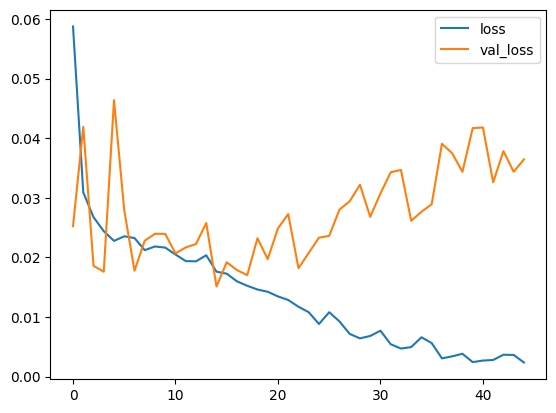

In [30]:
for j in range(n_reruns):
  # Model Creation
  tf.keras.backend.clear_session() 
  tf.keras.utils.set_random_seed(seed)
  #tf.config.experimental.enable_op_determinism()

  model = keras.Sequential()


  if Method=='RNN':
      Layer_type=SimpleRNN
  elif Method=='LSTM':
      Layer_type=LSTM
  elif Method=='GRU':
      Layer_type=GRU

  n_timesteps = X_train_seq.shape[1]

  n_features  = X_train_seq.shape[2]

  input_shape=(n_timesteps,n_features)
  for i in enumerate(neurons):
      if i[0]==len(neurons)-1:
          model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=False))   
      else:
          model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=True))     

  for i in enumerate(dens_neu):
      model.add(keras.layers.Dense(i[1], activation=act))


  model.add(keras.layers.Dense(1, activation='sigmoid'))


  #Best model so far is here
  #Compile Model
  model.compile(loss=loss, optimizer=Adam(learning_rate=learning_rate))
  #model.compile(loss=loss, optimizer='adam')
  #Train Model
  print("Training Model no {}".format(j+1))
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
  history = model.fit(verbose = 0,
                          x = X_train_seq,
                          y = y_train_seq,
                          batch_size=batch,
                          epochs=epochs,     
                          validation_split=0.2,
                          #validation_data=(X_valid_seq, y_valid_seq),
                          shuffle=False,
                          validation_steps=None,
                          validation_freq=1,
                          workers=4,
                          use_multiprocessing=False,
                          callbacks=[callback]
                          )

  # print loss curve

  history_df = pd.DataFrame(history.history)
  history_df.loc[0:, ['loss', 'val_loss']].plot()
  print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));


  # Save Model
  export_name = 'GRU_rerun_model_'+str(j+1)
  model.save(export_name)

  # Test Prediction
  # store scores for each model in a dictionary
  y_test_pred=model.predict(X_test_seq).round()
  f1, t_f1, hss, t_hss = errors_classification(y_test_seq, y_test_pred, transitions=True, transition_pos=t_indices_test)
  fm_scores['f1'].append(f1)
  fm_scores['t_f1'].append(t_f1)
  fm_scores['hss'].append(hss)
  fm_scores['t_hss'].append(t_hss)
  
  print("-"*100)
  print()

In [31]:
# save results
with open(os.path.join(path, 'results/gru_final_scores.pickle'), 'wb') as file:
  pickle.dump(fm_scores, file)

In [ ]:
# load in results of GRU on the unseen test set
with open(os.path.join(path, 'results/gru_final_scores.pickle'), 'rb') as file:
  fm_scores = pickle.load(file)

In [32]:
performance_report(fm_scores)

Validation Scores
------------------------------
f1
Scores: [50.68493150684932]
Mean: 50.685

t_f1
Scores: [34.17721518987342]
Mean: 34.177

hss
Scores: [0.5027]
Mean: 0.503

t_hss
Scores: [0.0]
Mean: 0.000



In [ ]:
!pip install -U neptune-client
import neptune.new as neptune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 562.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 3.3 MB/s eta 0:00:00


In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-56/metadata


In [ ]:
vars_sel

['vis',
 'temp_dew_dist',
 'rh',
 'ceiling',
 'duration',
 'hsig2',
 'dni',
 'dewpt',
 'drybulb',
 'cbl',
 'hlc',
 'ntot',
 'speed',
 'vp',
 'pchar',
 'dir']

In [ ]:
run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='GRU',
    description='trained 10 GRU models with the same parameters and evaluated each on the test set. Computed mean results',

)

performance_report(fm_scores)

run["algorithm"] = 'GRU'
run["params"] = params
run['features'] = "\n".join(vars_sel)

run['metrics/f1'] = np.round(np.mean(fm_scores['f1']), 2)
run['metrics/transition_f1'] = np.round(np.mean(fm_scores['t_f1']), 2)
run['metrics/hss'] = np.round(np.mean(fm_scores['hss']), 4)
run['metrics/transition_hss'] = np.round(np.mean(fm_scores['t_hss']), 4)


# only include this for compatible models
#run['metrics/pr_auc'] = final_scores['pr_auc']

# save Precision-Recall curve plot
#img_path = os.path.join(path, 'images/xgb_pr_curve.png')
#final_plots['pr_plot'].plot()
#plt.title("Precision-Recall Curve")
#plt.savefig(img_path)

#run['plots/pr_curve'].upload(img_path)

#run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(final_model, X_train, X_test, y_train, y_test)

run.stop()


<ipython-input-31-aa6e39937f16>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/swiatej2/fyp/e/FYP-63
Validation Scores
------------------------------
f1
Scores: [50.68493150684932, 50.68493150684932, 50.68493150684932, 50.68493150684932, 50.68493150684932, 50.68493150684932, 50.68493150684932, 50.68493150684932, 50.68493150684932, 50.68493150684932]
Mean: 50.685

t_f1
Scores: [34.17721518987342, 34.17721518987342, 34.17721518987342, 34.17721518987342, 34.17721518987342, 34.17721518987342, 34.17721518987342, 34.17721518987342, 34.17721518987342, 34.17721518987342]
Mean: 34.177

hss
Scores: [0.5027, 0.5027, 0.5027, 0.5027, 0.5027, 0.5027, 0.5027, 0.5027, 0.5027, 0.5027]
Mean: 0.503

t_hss
Scores: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Mean: 0.000

Shutting down background jobs, please wait a moment...


<ipython-input-31-aa6e39937f16>:12: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run["params"] = params


Done!
Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.
All 13 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-63/metadata


## Fog Formation Eval

We saw from the performance metrics that the model can predict fog states with some success, but overall fail to predict fog state transitions. As in, they can't predict accurately when a fog episode will begin. In this section, we evaluate how well the GRU model can predict fog episodes when we give wider margins of error.

**Result:**
- When considering longer lead-times, GRU model caught more transitions than for just the 1 hour lead time, but not significantly more. The model detected very few fog formations at 1 hr lead time, but showed more success at identifying fog formations than the best ML model.

**Notes:**
- Actual vs Predicted plot shows that the model is identifying fog episodes.
- Closer look at actual vs predicted tables shows that the model has a close false positive and false negative rates. Although the misclassification rate is higher than the best ML model (XGBoost)
- GRU managed to catch a few fog formations perfectly, but the results are still not satisfactory in this area (6/52) formations
- Analysing the 32 cases of fog formation predictions to see if there was actually fog formation within 3 hours, 6 hours, and 12 hours, we see that when the model predicted fog, there was fog within 3 to 6 hours in 19% of cases, and within 12 hours in 22% of cases.
 <br>



In [33]:
y_test_pred.flatten()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [34]:
y_pred = pd.Series(y_test_pred.flatten().astype(int), index=df_test.iloc[4:].index, name='pred')

In [35]:
y_test = pd.Series(y_test_seq.astype(int), index=df_test.iloc[4:].index, name='label')

In [36]:
target_df = pd.DataFrame({'pred': np.round(y_pred), 'label': y_test})

In [37]:
# build predicted fog state transition variables
formation = []
dissipation = []
fog_flag = False
for index, row in target_df.iterrows():
  # case 1: fog formation
  if row['pred'] == 1 and not fog_flag:
    formation.append(1)
    dissipation.append(0)
    fog_flag = True
  # case 2: fog dissipation
  elif row['pred'] == 0 and fog_flag:
    dissipation.append(1)
    formation.append(0)
    fog_flag = False
  # case 3: not a fog transition
  else:
    formation.append(0)
    dissipation.append(0)

target_df['pred_formation'] = formation
target_df['pred_dissipation'] = dissipation
#target_df['pred_transition'] = np.where((target_df.pred_formation == 1)|(target_df.pred_dissipation == 1), 1, 0)

In [38]:
# add ground truth fog state transition variables
target_df['formation'] = df_test.iloc[4:]['fog_formation']
target_df['dissipation'] = df_test.iloc[4:]['fog_dissipation']
target_df['fog_state'] = df_test.iloc[4:]['fog_state']

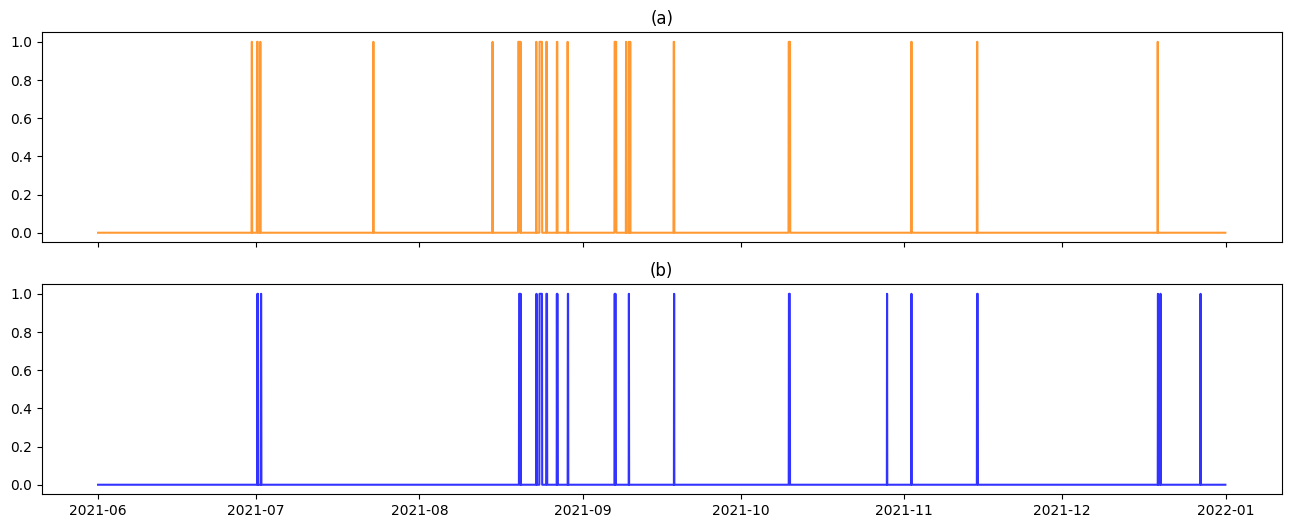

In [39]:
# (a) is actual fog episodes in second half of 2021
# (b) is predicted fog episodes by best model in second half of 2021
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

ax1.plot(target_df.loc[target_df.index >= '2021-06', ['label']], 
         alpha=0.8, linestyle='-', color='#FF8000')
ax1.set_title('(a)')

ax2.plot(target_df.loc[target_df.index >= '2021-06', ['pred']], 
         alpha=0.8, linestyle='-', color='blue')
ax2.set_title('(b)')

ax1.grid(False)
ax2.grid(False)

plt.show()

In [40]:
# model tends to underpredict fog rather than overpredict
target_df.loc[:,['pred', 'label']].value_counts()

pred  label
0     0        17322
      1           74
1     1           74
      0           70
dtype: int64

In [41]:
# in 32 cases, predicts fog formation in an hour, but it didn't occur in an hour
# There are less cases here when the model predicts fog formation and there is already fog. (25/57)
target_df.loc[:,['pred_formation', 'label']].value_counts()

pred_formation  label
0               0        17360
                1          123
1               0           32
                1           25
dtype: int64

In [42]:
# the model successfully predicted 6 fog formations within an hour.
target_df.loc[:,['pred_formation', 'formation']].value_counts()

pred_formation  formation
0               0            17437
1               0               51
0               1               46
1               1                6
dtype: int64

In [43]:
# model is fairly balanced in terms of incorrect predictions
confusion_matrix(target_df['pred'], target_df['label'])

array([[17322,    74],
       [   70,    74]])

In [44]:
# get the indices of target_df where fog formation predicted but there wasn't fog yet.
td_no_idx = target_df.reset_index()
pred_form_idx = td_no_idx.loc[(td_no_idx['pred_formation'] == 1) & (td_no_idx['label'] == 0), ['pred', 'pred_formation', 'label']].index

In [45]:
# In comparison to the xgboost model, much fewer of the fog formation misclassifications are fog dissipations.
td_no_idx.iloc[pred_form_idx]

,date_time,pred,label,pred_formation,pred_dissipation,formation,dissipation,fog_state
210,2020-01-09 22:00:00,1,0,1,0,0,0,no fog
499,2020-01-21 23:00:00,1,0,1,0,0,0,no fog
501,2020-01-22 01:00:00,1,0,1,0,0,0,no fog
523,2020-01-22 23:00:00,1,0,1,0,0,0,no fog
541,2020-01-23 17:00:00,1,0,1,0,0,0,no fog
1538,2020-03-05 06:00:00,1,0,1,0,0,0,no fog
3951,2020-06-13 19:00:00,1,0,1,0,0,0,no fog
5328,2020-08-10 04:00:00,1,0,1,0,0,0,no fog
5448,2020-08-15 04:00:00,1,0,1,0,0,0,no fog
5457,2020-08-15 13:00:00,1,0,1,0,0,0,no fog


In [46]:
# for each index in pred_form_idx, check the next indices for fog formation.
n_cases = len(pred_form_idx)
three_hr = 0
six_hr = 0
twelve_hr = 0
for idx in pred_form_idx:
  # 3hr lead time
  if any(td_no_idx.iloc[idx:idx+4,-3] == 1):
    twelve_hr += 1
    six_hr += 1
    three_hr += 1
  # 6hr lead time - if formation within 6 hrs, then formation within 12 also
  elif any(td_no_idx.iloc[idx:idx+7,-3] == 1):
    six_hr += 1
    twelve_hr += 1
  elif any(td_no_idx.iloc[idx:idx+13,-3] == 1):
    twelve_hr += 1

In [47]:
three_hr_prop = np.round((three_hr / n_cases)*100, 2)
six_hr_prop = np.round((six_hr / n_cases)*100, 2)
twelve_hr_prop = np.round((twelve_hr / n_cases)*100, 2)

In [51]:
print("GRU fog onset predicitons:")
print("three hr lead time: {}/{}".format(three_hr, n_cases))
print("six hr lead time: {}/{}".format(six_hr, n_cases))
print("twelve hr lead time: {}/{}".format(twelve_hr, n_cases))

GRU fog onset predicitons:
three hr lead time: 6/32
six hr lead time: 6/32
twelve hr lead time: 7/32


In [50]:
print("GRU fog onset predicitons:")
print("% Of cases where model predicts fog and fog occurs within 3 hours: {}".format(three_hr_prop))
print("% Of cases where model predicts fog and fog occurs within 6 hours: {}".format(six_hr_prop))
print("% Of cases where model predicts fog and fog occurs within 12 hours: {}".format(twelve_hr_prop))

GRU fog onset predicitons:
% Of cases where model predicts fog and fog occurs within 3 hours: 18.75
% Of cases where model predicts fog and fog occurs within 6 hours: 18.75
% Of cases where model predicts fog and fog occurs within 12 hours: 21.88
